# Residential location choice with multiple types

We introduce different types into the model of residential location choice.

Let's start by reviewing the main equations that we will use to compute the equilibrium. First, the consumers' utility maximization problem is
\begin{align*}
&\max\limits_{s,c}\{u(c,s)\}\\
&pc+r(x)s = y-tx
\end{align*}
Since we are interested in individual demand for land, we can use budget constrain to exclude consumption from the problem:
\begin{equation*}
s^{\ast}(r(x),p,y,x) = \arg\max\limits_{s}\left\{u\left(\frac{y-tx-r(x)s}{p},s \right)\right\}
\end{equation*}
Keep in mind that the parameters that enter this problem are type-specific.

The condition that the indirect utility must be indepenent of the location (otherwise, some locations will not be populated in equilibrium) gives us the equation for bidding function
\begin{equation*}
\frac{d}{dx}b_i(x) = -\frac{t_i}{s_i^{\ast}(b_i(x),p,y_i-t_i x)}
\end{equation*}

The endogenous city boundary $x_B$ solves $r(x_B) = r_A$. The integral equation pins down prices at all locations except $x = 0$. In order to find the price in the center we solve the market clearing condition for land (type by type):
\begin{equation*}
N_i = \int\limits_{X_i}\frac{2\pi z dz}{s_i^{\ast}(b_i(z),p,y_i-t_iz)}
\end{equation*}

### Algorithm

We will use the following algorithm for computing the equilibrium:
1. For given prices we compute the individual demand for land.
2. Using the integral equation we compute the bidding functions, resulting prices (upper envelope of bidding functions) and locations occupied by different types.
4. Solve the market clearing condition for $b_i(0)$.

We cannot work with the continuum of locations directly, so we will intoduce a deterministic location grid with a small increment.  

### Implementation

We begin by defining consumer's preferences and individual demands. We can reuse the code from the previous class.

In [3]:
# using Pkg
# Pkg.add("Optim")
using Optim

function utilityfn(c,s)
#Utility function()
alpha = 0.3
rslt = (c.^alpha).*(s.^(1-alpha))
end;

function dmnd(trc, income, p, r_A, xx, rr)
#demand
nn = length(xx)
s_dmnd = zeros(nn,1)
c_dmnd = zeros(nn,1)
for ii in 1:nn
    utilityfn_lambda(s) = -utilityfn(max((income-trc*xx[ii]-rr[ii]*s)/p,0.0),max(s,0.0))
    s_dmnd[ii,1] = Optim.minimizer(optimize(utilityfn_lambda,0.0,max(0.0,(income-trc*xx[ii])/rr[ii])))
    c_dmnd[ii,1] = (income-trc*xx[ii]-rr[ii]*s_dmnd[ii,1])/p
end
return (c_dmnd, s_dmnd)
    end;

Now we can solve the equation for the bidding functions. This time we will not iterate it to find a fixed point. Instead, we will use the prices from the adjacent points on the grid as approximation to compute individual demands.

In [4]:
function findrent(trc, income, p, r_A, xx, r0)
#search for the solution to dr/dx = -t/s[r]

nn = length(xx)
rr = fill(r0, nn, 1)


for jj in 2:(nn-1)
    (c_dmnd, s_dmnd) = dmnd(trc, income, p, r_A, xx[jj], rr[jj])
    if s_dmnd[1] > 0.0
        rr[jj] = max(rr[jj-1]-trc*(xx[jj]-xx[jj-1])/s_dmnd[1] , 0.0)
        rr[jj+1] = rr[jj]
    else
        rr[jj] = 0.0
        rr[jj+1] = rr[jj]
    end
end

return rr

        end;

Finally, we can use market clearing condition to solve for $r(0)$. We use the binary search since we know that excess demand is monotone in $r(0)$. The first `while` look finds $r(0)$ large enough for the excess demand to be negative (recall, that this value is required to start the binary search). the second `while` loop solves the market clearing condition.

In [13]:
function findeq_het(trc, income, p, r_A, xx, N)
    #trc, income, N and uf are vectors
toler2 = 0.001
numberoftypes = length(trc)
numberoflocations = length(xx)
#rhs_mat = fill(0,numberoftypes,1)
bb = fill(r_A,numberoflocations,numberoftypes+1)
s_dmnd = similar(bb)
b0 = similar(trc)
rr = similar(xx)
dxx = similar(xx)
dxx[1] = 0.0
dxx[2:end] = xx[2:end]-xx[1:end-1]
xxdxx = xx.*dxx
xxdxx_zero = fill(0.0,numberoflocations,numberoftypes+1)
b0_init = fill(10.0,numberoftypes,1)

function findeqprice(b0)
for ii in 1:numberoftypes
    bb[:,ii] = findrent(trc[ii], income[ii], p, r_A, xx, abs(b0[ii]))
end;
(rr, allocation_ind) = findmax(bb,dims=2)
return (rr, allocation_ind, bb)
end;

function excessdemand(b0)
    rhs_mat = fill(0.0,numberoftypes,1)
    (rr, allocation_ind, bb) = findeqprice(b0)
    for ii in 1:numberoftypes
        (c_dmnd, s_dmnd[:,ii]) = dmnd(trc[ii], income[ii], p, r_A, xx, rr)   
        xxdxx_ii = copy(xxdxx_zero)
        xxdxx_ii[:,ii] = xxdxx
        rhs_mat[ii] = sum(2*pi*xxdxx_ii[allocation_ind]./s_dmnd[allocation_ind], dims=1)[1]-N[ii]
    end;
    quaderror = -rhs_mat'rhs_mat
    if isnan(quaderror[1])
        return -666666.6
    else
        return quaderror[1]
    end
end;

r_max = 2
toler3 = 100
b0_error_mat = fill(r_A,toler3^2,3);
ijk = 1

for ii in 0:(toler3-1), jj in 0:(toler3-1)
    b0_error_mat[ijk,1:2] = [r_A+(r_max-r_A)*ii/toler3  r_A+(r_max-r_A)*jj/toler3]
    b0_error_mat[ijk,3] = excessdemand(b0_error_mat[ijk,1:2])
    ijk += 1
end

(maxerr, b0_ind) = findmax(b0_error_mat[:,3])
println("Total square excess demand is $maxerr")
b0_eq = b0_error_mat[b0_ind,1:2]
(rr, allocation_ind, bb) = findeqprice(b0_eq)
return (rr, bb)

        end;


Once all this functions are defined we can run them on some parameters. For instance, we can set
\begin{align*}
&t = (1, 1)\\
&y = (1, 1.5)\\
&p = 1\\
&r_A = 0.2\\
&N = (1, 1)
\end{align*} and run the code to compute the prices.

In [15]:
#include("dmnd.jl")
#include("findrent.jl")
#include("utilityfn.jl")
#include("findeq.jl")
# using Pkg
# Pkg.add("Plots")
using Plots
pyplot()
# using Pkg
# Pkg.add("LaTeXStrings")
using LaTeXStrings
#gr()

p = 1.0
r_A = 1/5
grid_size = 1000
maxX = 1.6

xx = [(maxX/grid_size)*(ii-1) for ii in (1:grid_size)]

trc_mat = [1.0; 1.0]
income_mat = [1.0; 1.5]
N_mat = [1.0; 1.0]

(rr, bb) = findeq_het(trc_mat, income_mat, p, r_A, xx, N_mat);

Total square excess demand is -0.0003750675228193938


Now we can use the output to plot a graph of $r(x)$ and the bidding functions for different types.

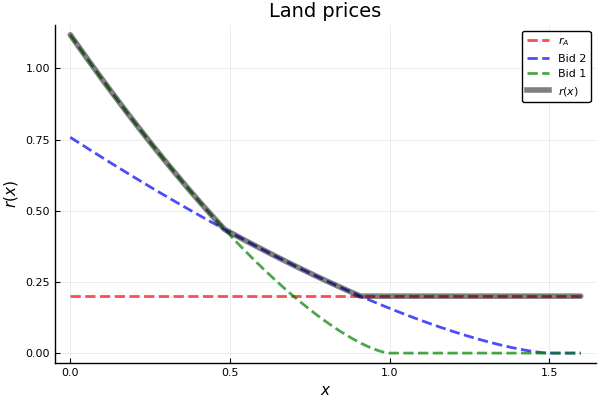

In [16]:

plot(xx, bb[:,3],
        seriestype = :line,
        linestyle = :dash,
        linealpha = 0.7,
        linewidth = 2,
        linecolor = :red,
        label = L"r_A")
xlabel!(L"x")
ylabel!(L"r(x)")
title!("Land prices")
plot!(xx, bb[:,2],
        seriestype = :line,
        linestyle = :dash,
        linealpha = 0.7,
        linewidth = 2,
        linecolor = :blue,
        label = "Bid 2")
plot!(xx, bb[:,1],
        seriestype = :line,
        linestyle = :dash,
        linealpha = 0.7,
        linewidth = 2,
        linecolor = :green,
        label = "Bid 1")
plot!(xx, rr,
        seriestype = :line,
        linestyle = :solid,
        linealpha = 0.5,
        linewidth = 4,
        linecolor = :black,
        label = L"r(x)")